
# Models using TFIDF vectors of abstracts




**ENVIRONMENT SETUP**

In [0]:
pip install prince

In [0]:
import pandas as pd
import numpy as np
import prince
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**DATA SETUP**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tfidf_df = pd.read_pickle("/content/drive/My Drive/ML/paper_data_tfidf_train.pkl") #pd.read_pickle("paper_data_tfidf_train.pkl")
train_data_indices = pd.read_pickle("/content/drive/My Drive/ML/train_data_paper_ids.pkl").tolist() #pd.read_pickle("train_data_paper_ids.pkl")
train_data_df = tfidf_df.loc[tfidf_df['paper_id'].isin(train_data_indices)]
test_data_df = tfidf_df.loc[~tfidf_df['paper_id'].isin(train_data_indices)]

In [0]:
#TRAIN DATA
X_train = np.vstack(train_data_df['tfidf_encoding'].values.tolist())
y_train = np.asarray([1 if item==True else 0 for item in list(train_data_df['accepted'])])

#TEST DATA
X_test = np.vstack(test_data_df['tfidf_encoding'].values.tolist())
y_test = np.asarray([1 if item==True else 0 for item in list(test_data_df['accepted'])])
print(X_train.shape)

(349, 6230)


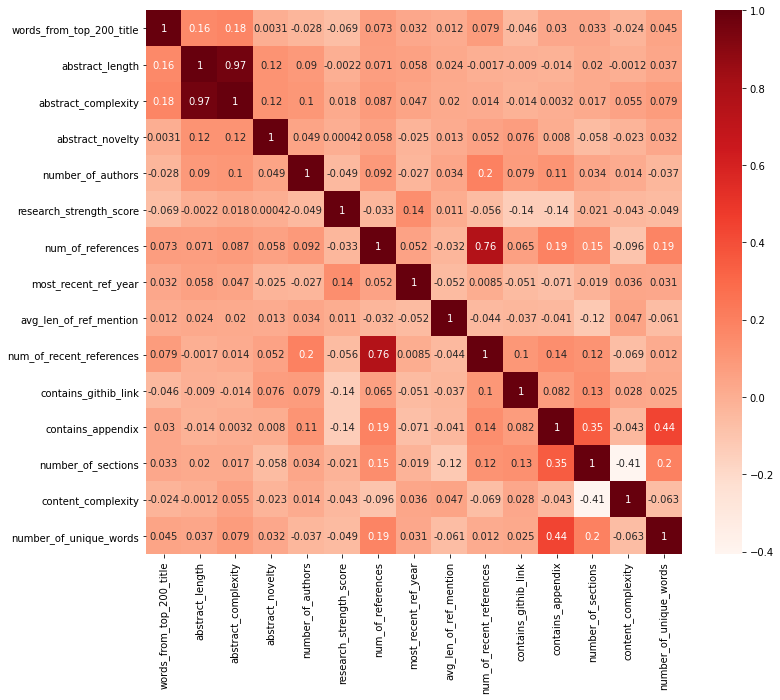

/content
['.config', 'tfidf_ComplementNB_model.sav', 'corr.png', 'correlation_analysis.png', 'tfidf_MultinomialNB_model.sav', 'svc_tfidf_model.sav', 'drive', 'explained_variance.png', 'sample_data']
Variance retained for  2  components =  0.3114003749022838
Variance retained for  3  components =  0.44317496590994576
Variance retained for  4  components =  0.543739484336
Variance retained for  5  components =  0.6281410575147229
Variance retained for  6  components =  0.7042295163911698
Variance retained for  7  components =  0.774026390332116
Variance retained for  8  components =  0.8393577505698261
Variance retained for  9  components =  0.8984498987238396
Variance retained for  10  components =  0.9401104361993413
Variance retained for  11  components =  0.9616918112717462
Variance retained for  12  components =  0.977297614997791
Variance retained for  13  components =  0.9902053987944962
Variance retained for  14  components =  0.9977488219674949
Variance retained for  15  compone

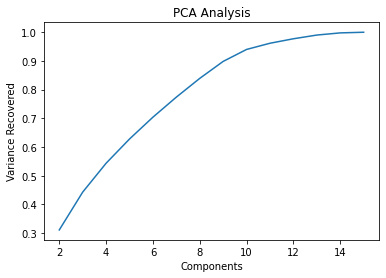

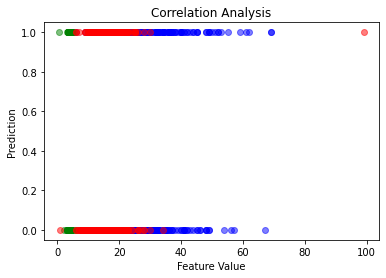

/content
['.config', 'tfidf_ComplementNB_model.sav', 'corr.png', 'correlation_analysis.png', 'tfidf_MultinomialNB_model.sav', 'svc_tfidf_model.sav', 'drive', 'corr2.png', 'explained_variance.png', 'sample_data']


<Figure size 432x288 with 0 Axes>

In [0]:
train_data_df = pd.read_pickle("/content/drive/My Drive/ML/paper_data_train.pkl")
train_data_features = train_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted'])
test_data_df = pd.read_pickle("/content/drive/My Drive/ML/paper_data_test.pkl")
test_data_features = test_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted'])
tf = pd.DataFrame(train_data_features)
plt.figure(figsize=(12,10))
cor = tf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.savefig('corr.png')
import os
print( os.getcwd() )
print( os.listdir() )
from google.colab import files
#files.download( "corr.png" )
explained_var = []

#TRAIN
for i in range(2,len(train_data_features.columns)+1):
    famd = prince.FAMD(n_components=i)
    famd = famd.fit(train_data_features)
    retained_variance = sum(famd.explained_inertia_)
    #var=np.cumsum(np.round(retained_variance, decimals=3)*100)
    #explained_variance_ratio = explained_variance / numpy.sum(explained_variance)
    explained_var.append(retained_variance)
    print("Variance retained for ",i," components = ",retained_variance)
    #if retained_variance > 0.95:
    #    break

num_components = i
famd = prince.FAMD(n_components=num_components)
famd = famd.fit(train_data_features)
train_data_features_famd = famd.transform(train_data_features)
X_train = train_data_features_famd.to_numpy()
y_train = np.asarray([1 if item==True else 0 for item in list(train_data_df['accepted'])])

#TEST 
test_data_famd = famd.transform(test_data_features)
X_test = test_data_famd.to_numpy()
y_test = np.asarray([1 if item==True else 0 for item in list(test_data_df['accepted'])])

plt.xlabel('Components')
plt.ylabel('Variance Recovered')
plt.title('PCA Analysis')
X = range(2, 16)
plt.style.context('seaborn-whitegrid')
plt.plot(X,explained_var)
plt.savefig('explained_variance.png')
import os
print( os.getcwd() )
print( os.listdir() )
from google.colab import files
#files.download( "explained_variance.png" )
explained_var = []

#df_xtrain=pd.DataFrame(train_data_df)
#print(list(df_xtrain))

plt.figure(2)
res = train_data_df['accepted'].astype(int)
train_data_df['accepted'] = res
df_num_of_features = train_data_df['num_of_references']
df_content_comp = train_data_df['content_complexity']
df_num_of_sections = train_data_df['number_of_sections']
df_accepted = train_data_df['accepted']

plt.scatter(df_num_of_features, df_accepted, alpha=0.5, color='blue')
plt.scatter(df_content_comp, df_accepted, alpha=0.5, color='green')
plt.scatter(df_num_of_sections, df_accepted, alpha=0.5, color='red')
plt.xlabel('Feature Value')
plt.ylabel('Prediction')
plt.title('Correlation Analysis')
plt.show()
plt.savefig('corr2.png')
import os
print( os.getcwd() )
print( os.listdir() )
from google.colab import files
files.download( "corr2.png" )

**DIMENSION REDUCTION**

In [0]:
tfidf_vector_size = X_train.shape[1]+1
for i in tqdm(range(2,tfidf_vector_size)):
    pca = prince.PCA(n_components=i)
    pca = pca.fit(X_train)
    retained_variance = sum(pca.explained_inertia_)
    if retained_variance > 0.85:
        break
print("\nVariance retained for ",i," components = ",retained_variance)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

  4%|▍         | 263/6229 [01:57<1:19:34,  1.25it/s]


Variance retained for  265  components =  0.851429678766944




---

**COMPLEMENT NAIVE BAYES**

---


In [0]:
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': np.linspace(0,5, num=1000)}
tfidf_ComplementNB = ComplementNB()
clf_tfidf_ComplementNB = GridSearchCV(tfidf_ComplementNB, parameters,verbose=1,cv=10,n_jobs=-1)

In [0]:
#TRAIN
clf_tfidf_ComplementNB.fit(X_train,y_train)
#SAVE MODEL
import pickle
filename = 'tfidf_ComplementNB_model.sav'
pickle.dump(clf_tfidf_ComplementNB, open(filename, 'wb'))

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 9816 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.7min finished


In [0]:
#VALIDATION SCORE
best_params = clf_tfidf_ComplementNB.best_params_
val_score = clf_tfidf_ComplementNB.best_score_
print(best_params)
print("VALIDATION SCORE =",val_score)

{'alpha': 3.4034034034034035}
VALIDATION SCORE = 0.601764705882353


In [0]:
#TEST SCORE 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
clf_predictions = clf_tfidf_ComplementNB.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))
print(accuracy_score(y_test,clf_predictions))

[[43  1]
 [31  2]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73        44
           1       0.67      0.06      0.11        33

    accuracy                           0.58        77
   macro avg       0.62      0.52      0.42        77
weighted avg       0.62      0.58      0.46        77

0.5844155844155844



---

**MULTINOMIAL NAIVE BAYES**

---


In [0]:
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': np.linspace(0,5, num=1000)}
tfidf_MultinomialNB = MultinomialNB()
clf_tfidf_MultinomialNB = GridSearchCV(tfidf_MultinomialNB, parameters,verbose=1,cv=10,n_jobs=-1)

In [0]:
#TRAIN
clf_tfidf_MultinomialNB.fit(X_train,y_train)
#SAVE
import pickle
filename = 'tfidf_MultinomialNB_model.sav'
pickle.dump(clf_tfidf_MultinomialNB, open(filename, 'wb'))

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3500 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 6300 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9900 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.7min finished


In [0]:
#VALIDATION SCORE
best_params = clf_tfidf_MultinomialNB.best_params_
val_score = clf_tfidf_MultinomialNB.best_score_
print(best_params)
print("VALIDATION SCORE =",val_score)

{'alpha': 0.34034034034034033}
VALIDATION SCORE = 0.6018487394957983


In [0]:
#TEST SCORE 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
clf_predictions = clf_tfidf_MultinomialNB.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))
print(accuracy_score(y_test,clf_predictions))

[[40  4]
 [29  4]]
              precision    recall  f1-score   support

           0       0.58      0.91      0.71        44
           1       0.50      0.12      0.20        33

    accuracy                           0.57        77
   macro avg       0.54      0.52      0.45        77
weighted avg       0.55      0.57      0.49        77

0.5714285714285714




---



**SVC (SVM)**

---



In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf','poly','sigmoid'), 'gamma':np.arange(1e-4,1e-2,0.002),'C':range(1,100)}
tfidf_svc = SVC()
clf_tfidf_svc = GridSearchCV(tfidf_svc, parameters,verbose=1,cv=10,n_jobs=-1)

In [0]:
clf_tfidf_svc.fit(X_train_reduced,y_train)
filename = 'svc_tfidf_model.sav'
pickle.dump(clf_tfidf_svc, open(filename, 'wb'))

Fitting 10 folds for each of 1485 candidates, totalling 14850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 734 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3134 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4934 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7134 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9734 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 12734 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 14850 out of 14850 | elapsed:  7.1min finished


In [0]:
#VALIDATION SCORE
best_params = clf_tfidf_svc.best_params_
val_score = clf_tfidf_svc.best_score_
print(best_params)
print("VALIDATION SCORE =",val_score)

{'C': 1, 'gamma': 0.0021, 'kernel': 'poly'}
VALIDATION SCORE = 0.6046218487394958


In [0]:
#TEST SCORE 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
clf_predictions = clf_tfidf_svc.predict(X_test_reduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))
print(accuracy_score(y_test,clf_predictions))

[[44  0]
 [33  0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        44
           1       0.00      0.00      0.00        33

    accuracy                           0.57        77
   macro avg       0.29      0.50      0.36        77
weighted avg       0.33      0.57      0.42        77

0.5714285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---


**RANDOM FOREST**

---



In [0]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf = RandomForestClassifier()
clf = GridSearchCV(rf, random_grid, cv = 5, verbose=1, n_jobs = -1)

{'n_estimators': [200, 1100, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [0]:

clf.fit(X_train_reduced,y_train)
cv_results = clf.cv_results_


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 47.0min finished


In [0]:
best_params = clf.best_params_
print(clf.best_estimator_)
print(best_params)
print(clf.best_score_)
best_clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_features=best_params['max_features'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], bootstrap=best_params['bootstrap'])
scores = cross_val_score(best_clf, X_train_reduced, y_train, cv=5)
print(scores.mean())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1100}
0.6103519668737061
0.5874120082815735


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
clf_predictions = clf.predict(X_test_reduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))
print(accuracy_score(y_test,clf_predictions))

[[44  0]
 [33  0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        44
           1       0.00      0.00      0.00        33

    accuracy                           0.57        77
   macro avg       0.29      0.50      0.36        77
weighted avg       0.33      0.57      0.42        77

0.5714285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))





---


**LOGISTIC REGRESSION**


---



In [0]:
from sklearn.linear_model import LogisticRegression
hyperparameters = {'penalty':('l1', 'l2'), 'C':np.logspace(0, 4, 100), 'fit_intercept':(True, False), 'class_weight':(None, 'balanced')}
logistic = LogisticRegression(solver = 'liblinear',max_iter=2000)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1,n_jobs=-1)

In [0]:
clf.fit(X_train_reduced,y_train)
cv_results = clf.cv_results_
best_params = clf.best_params_
print(clf.best_estimator_)
print(best_params)
print(clf.best_score_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.3min


LogisticRegression(C=351.11917342151344, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 351.11917342151344, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1'}
0.5272049689440994


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.6min finished


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
clf_predictions = clf.predict(X_test_reduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))
print(accuracy_score(y_test,clf_predictions))

[[30 14]
 [22 11]]
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        44
           1       0.44      0.33      0.38        33

    accuracy                           0.53        77
   macro avg       0.51      0.51      0.50        77
weighted avg       0.52      0.53      0.52        77

0.5324675324675324
